#第三節課 - 利用 Transformer 檢測葡萄病害
## 葡萄病徵的物件檢測 Object Detection

### 前置作業－下載專案、指定路徑

In [1]:
# 下載葡萄病徵檢測專案
! git clone https://gitlab.com/prophet.ai.inc/grape-disease-detection-tutorial.git

Cloning into 'grape-disease-detection-tutorial'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 50 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [2]:
# 指定路徑到專案資料夾
%cd /content/grape-disease-detection-tutorial

/content/grape-disease-detection-tutorial


### 前置作業－載入套件

In [3]:
# 載入程式所需的Python套件
import os
import cv2
import torch
import argparse
import numpy as np
from pathlib import Path
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# 載入程式套件
## 物件檢測
from models import build_model
from datasets.grape import make_grape_transforms
from detr_model import get_args_parser,rescale_bboxes
## 異常檢測
from padim_inference import padim
from padim_show_result import plot_fig
from torchvision.models import resnet18

In [4]:
!

### 前置作業－定義函數

In [5]:
def crop_one_grape(img, bboxes_scaled, output_name):#裁剪葡萄圖片
  n = 0
  for i in bboxes_scaled:
      if(i[0] < 0):
          i[0] = 0
      if(i[1] < 0):
          i[1] = 0
      if(i[2] < 0):
          i[2] = 0
      if(i[3] < 0):
          i[3] = 0
      im = img[int(i[1]):int(i[3]),int(i[0]):int(i[2])]
      save_path_file = os.path.join(output_name +str(n)+".jpg")
      im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
      cv2.imwrite(save_path_file, im)
      n += 1
     

def plot_results(pil_img, prob, boxes, thresh):
    COLORS = ["#00ff00", "#8B0000", "#E60000", "#B8860B", "#FFD700"]
    CLASSES = ['normal', 'earlybitter', 'bitter', 'earlyripe', 'ripe']
    bitter = 0
    ripe = 0
    normal = 0
    bitter_boxes = []
    ripe_boxes = []
    normal_boxes = []

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        if CLASSES[cl]=="normal":
            thick = 2
            normal += 1
            normal_boxes.append([xmin, ymin, xmax, ymax])
        elif CLASSES[cl]=="earlybitter" or CLASSES[cl]=="bitter":
            thick = 2
            bitter += 1
            bitter_boxes.append([xmin, ymin, xmax, ymax])
        elif CLASSES[cl]=="earlyripe" or CLASSES[cl]=="ripe":
            thick = 2
            ripe += 1
            ripe_boxes.append([xmin, ymin, xmax, ymax])
        else:
            thick = 2.5
        if(colors[cl]=="#00ff00"):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=colors[cl], linewidth=thick))
        else:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=True, color=colors[cl], linewidth=thick,alpha = 0.5))
                                
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='white', alpha = thresh))
    plt.axis('off')
    plt.show()
    return normal, bitter, ripe, normal_boxes, bitter_boxes, ripe_boxes

def detr(orig_image, model, device, threshold):
    model.eval()
    w, h = orig_image.size
    transform = make_grape_transforms("val")
    dummy_target = {
        "size": torch.as_tensor([int(h), int(w)]),
        "orig_size": torch.as_tensor([int(h), int(w)])
    }
    image, targets = transform(orig_image, dummy_target)
    image = image.unsqueeze(0)
    
    image = image.to(device)

    outputs = model(image)
    outputs["pred_logits"] = outputs["pred_logits"].cpu()
    outputs["pred_boxes"] = outputs["pred_boxes"].cpu()

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], orig_image.size)
    probas = probas[keep].cpu().data.numpy()

    return bboxes_scaled,probas

### 前置作業－下載模型權重

In [6]:
# 物件鑑測模型權重
!gdown -O checkpoint.pth "1O9SdcSO1CZ83NPCH3Ba_nB5JDDWwPNNJ&confirm=t"
# 異常檢測模型權重
!gdown -O train_grape.pkl "19znTbCzIdYfftl7zn1NuURYbAeZx7MKL&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1O9SdcSO1CZ83NPCH3Ba_nB5JDDWwPNNJ&confirm=t
To: /content/grape-disease-detection-tutorial/checkpoint.pth
100% 497M/497M [00:02<00:00, 208MB/s]
Downloading...
From: https://drive.google.com/uc?id=19znTbCzIdYfftl7zn1NuURYbAeZx7MKL&confirm=t
To: /content/grape-disease-detection-tutorial/train_grape.pkl
100% 127M/127M [00:00<00:00, 167MB/s]


### 載入欲辨識的葡萄影像

In [7]:
# # 自行上傳影像（請上傳整串完整葡萄影像，以免辨識有誤）
# # 執行前，先解開註解，並在「使用範本影像之程式碼加以註解」
# img_sample = files.upload()
# img_path = list(img_sample.keys())[0]

# 使用範本影像 (# disease_0001.jpg, disease_0002.jpg, disease_0003.jpg)
img_path = "test_img/disease_0003.jpg" 


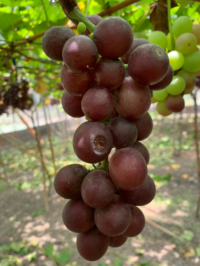

In [8]:
# 讀取影像
orig_image = Image.open(img_path)
orig_image = ImageOps.exif_transpose(orig_image)

# 顯示影像
show_orgim = orig_image.copy()
width = 200 ### (可修改影像的顯示大小)
show_orgim = show_orgim.resize( (width, int(show_orgim.size[1]* float(width)/show_orgim.size[0])), Image.BILINEAR ) 
display(show_orgim)

### Setting Model Parameter 設定神經網路模型相關參數

In [9]:
od_parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
od_args = od_parser.parse_args(args=[])
device = torch.device(od_args.device)
model, _, postprocessors = build_model(od_args)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
if od_args.resume:
    checkpoint = torch.load(od_args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
model.to(device)

threshold = 0.5

### Inference

In [11]:
B_Boxes,PR = detr(orig_image, model, device, threshold)

### Show Result Image

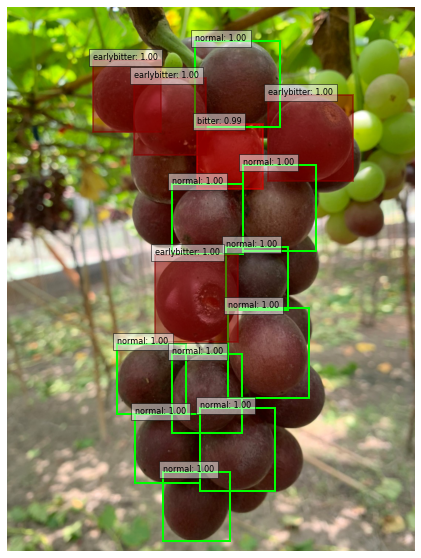

正常葡萄數量： 10 
苦腐病葡萄數量: 5 
晚腐病葡萄數量: 0


In [12]:
if len(B_Boxes) == 0:
      pass
img = np.array(orig_image)

single_normal, single_bitter, single_ripe, normal_boxes, bitter_boxes, ripe_boxes = plot_results(img, PR, B_Boxes, threshold)
print("正常葡萄數量：", single_normal,
      "\n苦腐病葡萄數量:", single_bitter,
      "\n晚腐病葡萄數量:", single_ripe)

### 裁切單顆葡萄影像
- 作為 異常檢測模型(Anomaly detection)輸入資料

In [13]:
save_path = "./single_grape_images/"
if not os.path.isdir(save_path):
    os.mkdir(save_path)
# 儲存"無病害"之單顆葡萄影像
normal_result_name = "normal_"
crop_one_grape(img, normal_boxes, save_path + normal_result_name)

# 儲存"苦腐病(bitter)"之單顆葡萄影像
bitter_result_name = "bitter_"
crop_one_grape(img, bitter_boxes, save_path + bitter_result_name)

# 儲存"無病害(ripe)"之單顆葡萄影像
ripe_result_name = "ripe_"
crop_one_grape(img, ripe_boxes, save_path + ripe_result_name)


## 使用 Transformer 進行 Anomaly Detection

### 讀取單顆葡萄之影像

In [14]:
normal_file_list = []
bitter_file_list = []
ripe_file_list = []

file_list = os.listdir("./single_grape_images/")
for file_name in file_list:
  if "normal" in file_name:
    normal_file_list.append(file_name)
  elif "bitter" in file_name:
    bitter_file_list.append(file_name)
  elif "ripe" in file_name:
    ripe_file_list.append(file_name)

disease_file_list = bitter_file_list + ripe_file_list

### Device Setup / Load Model

In [15]:
train_pth = "/content/grape-disease-detection-tutorial/train_grape.pkl"
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

model = resnet18(pretrained=False, progress=True)
t_d = 448
d = 100

model.to(device)
model.eval()


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Inference

In [16]:
dir_path = "/content/grape-disease-detection-tutorial/single_grape_images/"
scores = padim(dir_path,train_pth,model,device)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


load train set feature from: /content/grape-disease-detection-tutorial/train_grape.pkl


### Show Result Image

(238, 227, 3)
bitter_2.jpg


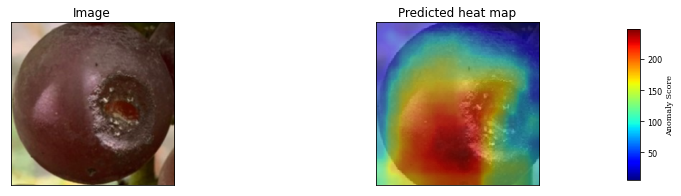

In [17]:
#檢測單顆葡萄影像
file_list = os.listdir(dir_path)
image_name = disease_file_list[1]
image_path = dir_path + image_name
idx = file_list.index(image_name)
#處理檢測影像
res_img = cv2.imread(image_path)
print(res_img.shape)
res_img = cv2.cvtColor(res_img,cv2.COLOR_BGR2RGB)
res_img = cv2.resize(res_img, (244,244))
print(image_name)
plot_fig(res_img, scores[idx])